### Tuning hyper-paremter of cortical cell classifier

In [1]:
# Importing libraries
import sys
sys.path.insert(0,
                '/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Tuning_parameters/')

from constants import * 
from base import *
from custom_metrics import *
from tuning_cv import *

In [2]:
## Importing libraries 
import pandas as pd
import numpy as np 
import random 

from sklearn import preprocessing 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

### Importing data 

In [3]:
# Annotated cells 
cell_path = "/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Training_data/Cortex/cells/"
cell_training = "training.txt"

# NNB information of all cells on slide
nnb_path = "/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Training_data/Cortex/NNB/"
nnb_training = "training_NNB.txt"

# hema nucleus of all cells on slide
hema_path = "/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Training_data/Cortex/hema/"
hema_training = "training_hema.txt"

Require: 
1. input_files.txt - to contian filenames I want to use. ** currently .csv files

In [14]:
# Importing annotated cells 

# obtaining list of files 
with open(cell_path + cell_training) as f: 
    mylist= f.read().splitlines()
    
print("Read in: ",len(mylist),"files")

# reading in all those files 
inputs = [] 
for i in mylist: 
    dat_ = pd.read_csv(cell_path + i,sep=",")
    dat_.columns.values[5] = 'Centroid_X'
    dat_.columns.values[6] = 'Centroid_Y'
    dat = dat_[cell_extracted_features] # fixed extracted feature order
    inputs.append(dat)
print("Extracted:", len(inputs),"files")


Read in:  12 files
Extracted: 12 files


In [15]:
# Importing in neghbouring cells info (numbers)

with open(nnb_path + nnb_training) as f: 
    nb_mylist= f.read().splitlines()
    
print("Read in:",len(nb_mylist)," NUMBER OF neighbouring cells files")

# reading in all those files 
nb_inputs = []
nb_columns = [] 
for i in nb_mylist: 
    dat = pd.read_csv(nnb_path +i,sep=",")
    dat.columns.values[0] = 'X'
    dat.columns.values[1] = 'Y'
    nb_inputs.append(dat)
    nb_columns.append(dat.shape[1])
    
print("Extracted:", len(nb_inputs),"files")
print('no. of columns / NB file:', nb_columns)

Read in: 12  NUMBER OF neighbouring cells files
Extracted: 12 files
no. of columns / NB file: [13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13]


In [16]:
#  Importing hema nucleus mean of all detected cells & location coordinates 
# Variables: hema_mylist, hema_inputs 

## obtaining list of files 
with open(hema_path + hema_training) as f: 
    hema_mylist= f.read().splitlines()
    
print("Read in:",len(hema_mylist),"hema files")    


## 4) reading in all those files 
hema_inputs = [] 
for i in hema_mylist: 
    dat = pd.read_csv(hema_path + i,sep=",")
    dat.columns.values[0] = 'Centroid_X' # To fix naming inconsistency problem 
    dat.columns.values[1] = 'Centroid_Y'
    hema_inputs.append(dat)

print("Extracted:",len(hema_inputs),"hema files")  


Read in: 12 hema files
Extracted: 12 hema files


In [17]:
# Checking if filenames & order of them from mylist, nb_mylist & hema_mylist match
x_nb = [i[1:7] for i in nb_mylist]
x = [i[0:6] for i in mylist]
x_h = [i[0:6] for i in hema_mylist]
print("mylist & nb_list matched?:", x==x_nb)
print("mylist & hema_list matched?:",x==x_h)

mylist & nb_list matched?: True
mylist & hema_list matched?: True


In [18]:
# combine cells with NNB information
inputs_with_nbb, output_log = combine_annotated_to_NNB(annotated_list = inputs,
                                                        NNB_list = nb_inputs)
print(output_log)

[True, True, True, True, True, True, True, True, True, True, True, True]


In [19]:
# Find cells to remove based on hematoxylin staining (from normalisation, remove top 1%)
hema_to_remove = find_hema_to_remove(hema_inputs)

# for i in range(0,len(hema_to_remove)): 
#     print(i, " No. of cells with normalised Hema >1:",len(hema_to_remove[i]), "from", len(hema_inputs[i]),"detected cells")

In [20]:
# remove cells that have hema above criteria
cleaned_inputs, remove_log = remove_cell_hema(inputs_with_nbb,
                                              hema_to_remove)
print(remove_log)
print(cleaned_inputs[0].shape)

[True, True, True, True, True, True, True, True, True, True, True, True]
(566, 51)


### Putting the slides together 

In [21]:
##Variables: labelled_orig, labelled_data 
#1) Put the slides together

labelled_orig = pd.concat(cleaned_inputs)
print(labelled_orig.shape)

# 2) Extract relevant columns 
dat = labelled_orig.drop(columns=['Name','Parent','ROI']) 
dat.head()


(4717, 51)


,Image,Class,Centroid_X,Centroid_Y,Detection probability,Nucleus: Area µm^2,Nucleus: Length µm,Nucleus: Circularity,Nucleus: Solidity,Nucleus: Max diameter µm,...,NN_10_um,NN_20_um,NN_30_um,NN_40_um,NN_50_um,NN_60_um,NN_70_um,NN_80_um,NN_90_um,NN_100_um
0,703484.svs,fragmented,2758.4,5064.2,0.7102,10.4438,11.7588,0.9492,1.0000,4.2279,...,1,2,3,5,7,10,16,21,25,36
1,703484.svs,Epithelial,2865.6,5210.4,0.7737,34.4719,24.9365,0.6966,0.9739,10.6183,...,0,1,3,3,4,7,14,25,32,35
2,703484.svs,Epithelial,2929.0,5210.6,0.7337,23.0844,20.5225,0.6888,0.9821,8.7795,...,0,0,1,2,5,5,10,15,18,25
3,703484.svs,Ignore,2736.6,5224.5,0.5949,31.9419,20.3826,0.9662,1.0000,7.1633,...,0,0,0,1,7,13,15,20,28,35
4,703484.svs,fragmented,5262.3,5460.8,0.7159,9.8636,13.0301,0.7300,0.9790,5.4442,...,1,4,7,8,13,16,17,19,22,30


### Extracting relevant cell classes

In [22]:
# Make all class names lower case - easier for later selection

dat_lower_class = [i.lower() for i in dat['Class']]
dat2 = dat.copy()
dat2.loc[:,'Class'] = dat_lower_class 
dat2['Class'].value_counts()

neuron_new        885
oligo_new         792
epithelial_new    557
ignore            356
ignore_new        344
epithelial        330
fragmented        304
neuron            302
astro             297
oligo             295
astro_new         179
stardist_error     35
fragmented_new     25
tumor              16
Name: Class, dtype: int64

In [23]:
# Select only relevant cell classes (Using stardist_error instead of ignore_new)
dat3 = dat2[(dat2['Class'] == 'oligo_new') | (dat2['Class'] == 'neuron_new')
          | (dat2['Class'] == 'astro_new')| (dat2['Class'] == 'epithelial_new')
          | (dat2['Class'] == 'stardist_error')| (dat2['Class'] == 'fragmented_new')]
dat3=dat3.reset_index(drop=True)

# Checking results
dat3['Class'].value_counts()

neuron_new        885
oligo_new         792
epithelial_new    557
astro_new         179
stardist_error     35
fragmented_new     25
Name: Class, dtype: int64

In [24]:
# Re-name these classes so it has no '_new'
class_new = dat3['Class']
x = [(i[0:-4].capitalize()) for i in class_new]
#dat = dat_ 
dat3['Class'] = x
dat3['Class'].value_counts()

Neuron        885
Oligo         792
Epithelial    557
Astro         179
Stardist_e     35
Fragmented     25
Name: Class, dtype: int64

In [25]:
# Group Ignore, Epithelial & Fragmented cells as a single class called 'ta'
class_ = dat3['Class']
y = ['Others' if i == 'Epithelial' or i == 'Stardist_e' or i == 'Fragmented' else i for i in class_ ]
data = dat3
data['Class'] = y 
print(data['Class'].value_counts().sum())
data['Class'].value_counts()


2473


Neuron    885
Oligo     792
Others    617
Astro     179
Name: Class, dtype: int64

In [101]:
# Export cleaned data out for easy use: 
# path = '/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Cell_classification/cortical_training_data.txt'
# data.to_csv(path, sep="\t", index=False)

# Training the model

### Checking for any NA in the data

In [26]:
#checking for NAN 
## NEW 
print("Any NA in the data?: ",data.isnull().sum().sum()==1)

#dat = dat.dropna()
#dat.isnull().sum().sum()

Any NA in the data?:  False


### Create train, test sets 

In [27]:
#We are using the entire dataset to train the model, test data will be provided later by Sanne 
X_train_l = data.drop(columns=['Class'])
X_train = X_train_l.drop(columns=['Image','Centroid_X','Centroid_Y'])
print('training data shape:',X_train.shape)
y_train = data['Class']

training data shape: (2473, 44)


In [18]:
X_train.head()

,Detection probability,Nucleus: Area µm^2,Nucleus: Length µm,Nucleus: Circularity,Nucleus: Solidity,Nucleus: Max diameter µm,Nucleus: Min diameter µm,Cell: Area µm^2,Cell: Length µm,Cell: Circularity,...,NN_10_um,NN_20_um,NN_30_um,NN_40_um,NN_50_um,NN_60_um,NN_70_um,NN_80_um,NN_90_um,NN_100_um
0,0.8929,70.4335,30.1589,0.9731,1.0000,10.5379,8.6989,258.8036,60.0120,0.9030,...,0,2,3,7,9,12,14,18,28,36
1,0.6650,69.3602,30.0618,0.9645,1.0000,10.3145,8.9289,289.4437,60.9183,0.9801,...,0,3,4,8,8,9,17,22,27,35
2,0.9025,21.2553,16.7824,0.9483,1.0000,6.1317,4.5305,132.4307,42.3046,0.9299,...,0,2,4,5,10,13,15,18,22,35
3,0.7240,91.2679,34.9913,0.9367,0.9992,12.8068,8.8117,321.6940,65.4879,0.9426,...,0,2,2,5,8,14,19,26,33,40
4,0.8682,18.5580,15.5796,0.9608,1.0000,5.4150,4.4888,163.2746,45.8910,0.9743,...,0,0,1,7,12,15,17,22,28,37


In [62]:
pipeline_cell

Pipeline(steps=[('normalizer', MinMaxScaler()),
                ('selector',
                 RFE(estimator=RandomForestClassifier(random_state=42))),
                ('clf', BalancedRandomForestClassifier())])

### Hyperparameter tuning - random forest

In [20]:
# # Create the random grid 

rf_random = RandomizedSearchCV(pipeline_cell,
                             param_distributions=random_grid, 
                             n_iter=100,
                             cv=10,
                             verbose=2,
                            random_state=42,
                            n_jobs=-1,
                              refit='PR_AUC', # use this metric to evaluate performance of parameters 
                      scoring={'PR_AUC':precision_recall_auc,
                          'roc_auc_ovr_weighted':'roc_auc_ovr_weighted',
                            'roc_auc_ovo':'roc_auc_ovo',
                              'balanced_accuracy':'balanced_accuracy',
                               'f1_weighted':'f1_weighted',
                               'Astro_accuracy': astro_acc,
                               'Neuron_accuracy':neuron_acc,
                               'Oligo_accuracy':oligo_acc,
                               'Others_accuracy':others_acc,
                               'A_as_N':A_as_N,
                               'A_as_O':A_as_O,
                               'A_as_Others':A_as_Others,
                               'N_as_A':N_as_A,
                               'N_as_O':N_as_O,
                               'N_as_Others':N_as_Others,
                               'O_as_A':O_as_A,
                               'O_as_N':O_as_N,
                               'O_as_Others':O_as_Others,
                               'Others_as_A':Others_as_A,
                               'Others_as_N':Others_as_N,
                               'Others_as_O':Others_as_O
                              })

rf_random.fit(X_train,y_train)

print(rf_random.best_score_)
print(rf_random.best_params_)


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
0.8089723263878247
{'selector__n_features_to_select': 36, 'clf__sampling_strategy': 'all', 'clf__random_state': 42, 'clf__n_estimators': 1800, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_features': 'auto', 'clf__max_depth': 60, 'clf__ccp_alpha': 0.0, 'clf__bootstrap': False}


old param space {'selector__n_features_to_select': 36, 'clf__sampling_strategy': 'all', 'clf__random_state': 42, 'clf__n_estimators': 1800, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_features': 'auto', 'clf__max_depth': 60, 'clf__ccp_alpha': 0.0, 'clf__bootstrap': False}


new param space {'selector__n_features_to_select': 38, 'clf__sampling_strategy': 'not majority', 'clf__random_state': 42, 'clf__n_estimators': 900, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 4, 'clf__max_samples': 0.5, 'clf__max_features': 0.2, 'clf__max_depth': None, 'clf__class_weight': 'balanced'}


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
0.8092402569869004
{'selector__n_features_to_select': 32, 'clf__sampling_strategy': 'all', 'clf__random_state': 42, 'clf__n_estimators': 1400, 'clf__min_samples_split': 2,
 'clf__min_samples_leaf': 4, 'clf__max_features': 'sqrt', 'clf__max_depth': 10, 'clf__bootstrap': False}

In [23]:
# # Digging into more details 
print("PR-AUC:",
     rf_random.cv_results_['mean_test_PR_AUC'][rf_random.best_index_]*100)
print("ROC-AUC:",
     rf_random.cv_results_['mean_test_roc_auc_ovr_weighted'][rf_random.best_index_]*100)
print("ROC-AUC:",
     rf_random.cv_results_['mean_test_roc_auc_ovo'][rf_random.best_index_]*100)

print("Balanced accuracy:",
      rf_random.cv_results_['mean_test_balanced_accuracy'][rf_random.best_index_]*100)

print("F1_weighted:",
      rf_random.cv_results_['mean_test_f1_weighted'][rf_random.best_index_]*100)

print("Astrocyte accuracy:",
      rf_random.cv_results_['mean_test_Astro_accuracy'][rf_random.best_index_]*100)

print("Neuron accuracy:",
      rf_random.cv_results_['mean_test_Neuron_accuracy'][rf_random.best_index_]*100)

print("Oligo accuracy:",
      rf_random.cv_results_['mean_test_Oligo_accuracy'][rf_random.best_index_]*100)

print("Others accuracy:",
      rf_random.cv_results_['mean_test_Others_accuracy'][rf_random.best_index_]*100)


print("Classified A as N:",
      rf_random.cv_results_['mean_test_A_as_N'][rf_random.best_index_]*100)

print("Classified A as O:",
      rf_random.cv_results_['mean_test_A_as_O'][rf_random.best_index_]*100)

print("Classified A as Others:",
      rf_random.cv_results_['mean_test_A_as_Others'][rf_random.best_index_]*100)

print("Classified N as A:",
      rf_random.cv_results_['mean_test_N_as_A'][rf_random.best_index_]*100)

print("Classified N as O:",
      rf_random.cv_results_['mean_test_N_as_O'][rf_random.best_index_]*100)

print("Classified N as Others:",
      rf_random.cv_results_['mean_test_N_as_Others'][rf_random.best_index_]*100)

print("Classified O as A:",
      rf_random.cv_results_['mean_test_O_as_A'][rf_random.best_index_]*100)

print("Classified O as N:",
      rf_random.cv_results_['mean_test_O_as_N'][rf_random.best_index_]*100)

print("Classified O as Others:",
      rf_random.cv_results_['mean_test_O_as_Others'][rf_random.best_index_]*100)


print("Classified Others as A:",
      rf_random.cv_results_['mean_test_Others_as_A'][rf_random.best_index_]*100)

print("Classified Others as N:",
      rf_random.cv_results_['mean_test_Others_as_N'][rf_random.best_index_]*100)

print("Classified Others as O:",
      rf_random.cv_results_['mean_test_Others_as_O'][rf_random.best_index_]*100)
                                                       

PR-AUC: 80.89723263878247
ROC-AUC: 95.71905149600852
ROC-AUC: 94.52270168192489
Balanced accuracy: 80.46433524147317
F1_weighted: 81.21520062966688
Astrocyte accuracy: 83.20261437908496
Neuron accuracy: 83.81639427987743
Oligo accuracy: 78.54272151898735
Others accuracy: 76.29561078794288
Classified A as N: 6.11111111111111
Classified A as O: 5.098039215686274
Classified A as Others: 5.588235294117648
Classified N as A: 12.447650663942799
Classified N as O: 0.45454545454545453
Classified N as Others: 3.2814096016343206
Classified O as A: 9.606012658227849
Classified O as N: 0.12658227848101267
Classified O as Others: 11.724683544303797
Classified Others as A: 6.152829190904283
Classified Others as N: 6.673717609730301
Classified Others as O: 10.877842411422527


PR-AUC: 79.98806241134216
ROC-AUC: 95.11175682311132
ROC-AUC: 93.85632866833322
Balanced accuracy: 76.0252752628624
F1_weighted: 79.1078367947035
Astrocyte accuracy: 71.01307189542483
Neuron accuracy: 90.49412665985699
Oligo accuracy: 75.3860759493671
Others accuracy: 67.20782654680065
Classified A as N: 20.555555555555554
Classified A as O: 5.065359477124183
Classified A as Others: 3.3660130718954253
Classified N as A: 7.582992849846781
Classified N as O: 0.5669050051072523
Classified N as Others: 1.3559754851889683
Classified O as A: 13.022151898734178
Classified O as N: 0.25158227848101267
Classified O as Others: 11.340189873417721
Classified Others as A: 8.260179799048123
Classified Others as N: 14.952406134320464
Classified Others as O: 9.579587519830776

In [22]:
# save object using joblib
joblib.dump(rf_random, 'cortical_random_search_old_param.sav')

['cortical_random_search_old_param.sav']

## Manual cross validation, using PR curves

In [104]:
cortical_classifier_hyperparams = [
    ('normalizer', MinMaxScaler()),
    ('selector', RFE(estimator=RandomForestClassifier(random_state=42),
        n_features_to_select=38)),
    ('clf', BalancedRandomForestClassifier(
        random_state=42,
        sampling_strategy='not majority',
        n_estimators=900,
        min_samples_split=5,
        min_samples_leaf=4,
        max_features=0.2,
        max_depth=None,
        max_samples=0.5,
        class_weight='balanced'))]
        
# 10-fold cross validation
model = ClassifierTuning(hyperparameters=cortical_classifier_hyperparams)
model.find_bestparameters(X=X_train,
                          Y=y_train)

In [105]:
model.best_parameters

{0: (0.5052076758986506,
  0.5843123101910119,
  0.5443412365069623,
  0.7156862745098039),
 1: (0.5122703624147519,
  0.9112137156584529,
  0.9126933052503394,
  0.9105209397344227),
 2: (0.2828375714157505,
  0.8576644007790974,
  0.832396168021168,
  0.892610759493671),
 3: (0.28468038825335934,
  0.7667554546504622,
  0.7432463865928447,
  0.8087519830777368)}

{0: (0.5389444444444444,
  0.5994923353169026,
  0.5069224466206379,
  0.7431372549019608),
 1: (0.3241111111111111,
  0.9074376452538232,
  0.9075701002018992,
  0.9094739530132789),
 2: (0.3404444444444444,
  0.8643754408167077,
  0.8468744490367953,
  0.8877056962025318),
 3: (0.40361111111111114,
  0.7937482043404283,
  0.7880311226035037,
  0.8268905341089372)}

In [114]:
model.cv_withthresholding(best_parameters=model.best_parameters,
                          X=X_train,
                          Y=y_train,
                          X_location = X_train_l)

In [115]:
# Confusion matrix across 10 folds, WITH thresholding 
print('with thresholding (non-calibrated) ACC :', mean(model.cv_accuraciesT)*100)
print('Macro avg F1 ', 
      mean([i['macro avg']['f1-score'] for i in model.cv_reportsT])*100)
print('Weighted avg F1 ',
      mean([i['weighted avg']['f1-score'] for i in model.cv_reportsT])*100)
print("--------------------------")
cf_t = sum(model.cv_confusion_matricesT)
final_cm_t =  cf_t.astype('float') / cf_t.sum(axis=1)[:, np.newaxis]*100
print(cf_t)
print(final_cm_t)
print("--------------------------")
print("Astro accuracy",final_cm_t[0][0])
print("Neuron accuracy",final_cm_t[1][1])
print("Oligo accuracy",final_cm_t[2][2])
print("Oligo accuracy",final_cm_t[3][3])
print('------------------------------')
# F1-score per class: 
print('Astro f1-score ',mean([i['Astro']['f1-score'] for i in model.cv_reportsT])*100)
print('Astro precision ',mean([i['Astro']['precision'] for i in model.cv_reportsT])*100)
print('Astro recall ',mean([i['Astro']['recall'] for i in model.cv_reportsT])*100)
print("--------------------------")
print('Neuron f1-score ',mean([i['Neuron']['f1-score'] for i in model.cv_reportsT])*100)
print('Neuron precision ',mean([i['Neuron']['precision'] for i in model.cv_reportsT])*100)
print('Neuron recall ',mean([i['Neuron']['recall'] for i in model.cv_reportsT])*100)
print("--------------------------")
print('Oligo f1-score ',mean([i['Oligo']['f1-score'] for i in model.cv_reportsT])*100)
print('Oligo precision ',mean([i['Oligo']['precision'] for i in model.cv_reportsT])*100)
print('Oligo recall ',mean([i['Oligo']['recall'] for i in model.cv_reportsT])*100)
print("--------------------------")
print('Oligo f1-score ',mean([i['Oligo']['f1-score'] for i in model.cv_reportsT])*100)
print('Oligo precision ',mean([i['Oligo']['precision'] for i in model.cv_reportsT])*100)
print('Oligo recall ',mean([i['Oligo']['recall'] for i in model.cv_reportsT])*100)
print("--------------------------")
print('Macro avg precision',
      mean([i['macro avg']['precision'] for i in model.cv_reportsT])*100)
print('Macro avg recall ',
      mean([i['macro avg']['recall'] for i in model.cv_reportsT])*100)

with thresholding (non-calibrated) ACC : 79.75250191689582
Macro avg F1  77.52330200615246
Weighted avg F1  84.05670222494143
--------------------------
[[110  30  12   6]
 [ 48 783   2  14]
 [ 69   2 554  52]
 [ 25  60  34 385]]
[[69.62025316 18.98734177  7.59493671  3.79746835]
 [ 5.66706021 92.44391972  0.23612751  1.65289256]
 [10.19202363  0.29542097 81.83161004  7.68094535]
 [ 4.96031746 11.9047619   6.74603175 76.38888889]]
--------------------------
Astro accuracy 69.62025316455697
Neuron accuracy 92.44391971664699
Oligo accuracy 81.83161004431314
Oligo accuracy 76.38888888888889
------------------------------
Astro f1-score  54.15172906704662
Astro precision  45.573392308364774
Astro recall  69.30228758169935
--------------------------
Neuron f1-score  90.99008762001418
Neuron precision  89.89774301852952
Neuron recall  92.38928790849087
--------------------------
Oligo f1-score  85.4056955647144
Oligo precision  92.52327950161225
Oligo recall  81.22855048781936
--------------

In [116]:
model.cv_nothresholding(X=X_train,
                        Y=y_train,
                        X_location= X_train_l)

In [117]:
#Confusion matrix across 10 folds, WITHOUT thresholding 
print('with no thresholding:',
      mean(model.cv_accuracies)*100)
print('Macro avg F1 ',
      mean([i['macro avg']['f1-score'] for i in model.cv_reports])*100)
print('Weighted avg F1 ',
      mean([i['weighted avg']['f1-score'] for i in model.cv_reports])*100)
print("--------------------------")
cf = sum(model.cv_confusion_matrices)
final_cm =  cf.astype('float') / cf.sum(axis=1)[:, np.newaxis]*100
print(cf)
print(final_cm)
print("--------------------------")
print("Astro accuracy",final_cm[0][0])
print("Neuron accuracy",final_cm[1][1])
print("Oligo accuracy",final_cm[2][2])
print("Others accuracy",final_cm[3][3])
print('------------------------------')
# F1-score per class: 
print('Astro f1-score ',mean([i['Astro']['f1-score'] for i in model.cv_reports])*100)
print('Astro precision ',mean([i['Astro']['precision'] for i in model.cv_reports])*100)
print('Astro recall ',mean([i['Astro']['recall'] for i in model.cv_reports])*100)
print("--------------------------")
print('Neuron f1-score ',mean([i['Neuron']['f1-score'] for i in model.cv_reports])*100)
print('Neuron precision ',mean([i['Neuron']['precision'] for i in model.cv_reports])*100)
print('Neuron recall ',mean([i['Neuron']['recall'] for i in model.cv_reports])*100)
print("--------------------------")
print('Oligo f1-score ',mean([i['Oligo']['f1-score'] for i in model.cv_reports])*100)
print('Oligo precision ',mean([i['Oligo']['precision'] for i in model.cv_reports])*100)
print('Oligo recall ',mean([i['Oligo']['recall'] for i in model.cv_reports])*100)
print("--------------------------")
print('Others f1-score ',mean([i['Others']['f1-score'] for i in model.cv_reports])*100)
print('Others precision ',mean([i['Others']['precision'] for i in model.cv_reports])*100)
print('Others recall ',mean([i['Others']['recall'] for i in model.cv_reports])*100)
print("--------------------------")
print('Macro avg precision',
      mean([i['macro avg']['precision'] for i in model.cv_reports])*100)
print('Macro avg recall ',
      mean([i['macro avg']['recall'] for i in model.cv_reports])*100)

with no thresholding: 76.02527526286238
Macro avg F1  72.60259241107812
Weighted avg F1  79.10783679470352
--------------------------
[[127  37   9   6]
 [ 67 801   5  12]
 [103   2 597  90]
 [ 51  92  59 415]]
[[70.94972067 20.67039106  5.02793296  3.35195531]
 [ 7.57062147 90.50847458  0.56497175  1.3559322 ]
 [13.00505051  0.25252525 75.37878788 11.36363636]
 [ 8.26580227 14.910859    9.5623987  67.26094003]]
--------------------------
Astro accuracy 70.94972067039106
Neuron accuracy 90.5084745762712
Oligo accuracy 75.37878787878788
Others accuracy 67.26094003241491
------------------------------
Astro f1-score  48.78677598481728
Astro precision  37.78797409768505
Astro recall  71.01307189542484
--------------------------
Neuron f1-score  88.26574238636104
Neuron precision  86.4728435144782
Neuron recall  90.494126659857
--------------------------
Oligo f1-score  80.83233377213462
Oligo precision  89.78096627071396
Oligo recall  75.3860759493671
--------------------------
Others f1-

In [118]:
# save object using joblib
joblib.dump(model, 'cortical_cv_results.sav')

['cortical_cv_results.sav']

In [65]:
cortical_classifier_hyperparams

[('normalizer', MinMaxScaler()),
 ('selector',
  RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=38)),
 ('clf',
  BalancedRandomForestClassifier(class_weight='balanced', max_features=0.2,
                                 max_samples=0.5, min_samples_leaf=4,
                                 min_samples_split=5, n_estimators=900,
                                 random_state=42,
                                 sampling_strategy='not majority'))]

In [66]:
# Train final model
cortical_model = Pipeline(cortical_classifier_hyperparams)
final_model = cortical_model.fit(X_train,y_train)

In [68]:
joblib.dump(final_model, 'cortical_cell_classifier.sav')

['cortical_cell_classifier.sav']

Extracting information

In [4]:
# The final model
loaded_model = joblib.load('/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Tuning_parameters/Results/cortical_cv_results.sav')
cf_t = sum(loaded_model.cv_confusion_matricesT)
final_cm_t =  cf_t.astype('float') / cf_t.sum(axis=1)[:, np.newaxis]*100

In [5]:
# find out proportion of ambiguous cells 
predicted = (sum(loaded_model.cv_y_predictsT, []))
print('total:',len(predicted))
print(set(predicted))
amb_n = sum(1 for i in predicted if i =='Ambiguous')
print('Ambiguous: ',amb_n)
print('proportion Ambiguous: ', amb_n/len(predicted) )

total: 2473
{'Ambiguous', 'Others', 'Oligo', 'Neuron', 'Astro'}
Ambiguous:  287
proportion Ambiguous:  0.11605337646583097


In [6]:
final_cm_t

array([[69.62025316, 18.98734177,  7.59493671,  3.79746835],
       [ 5.66706021, 92.44391972,  0.23612751,  1.65289256],
       [10.19202363,  0.29542097, 81.83161004,  7.68094535],
       [ 4.96031746, 11.9047619 ,  6.74603175, 76.38888889]])

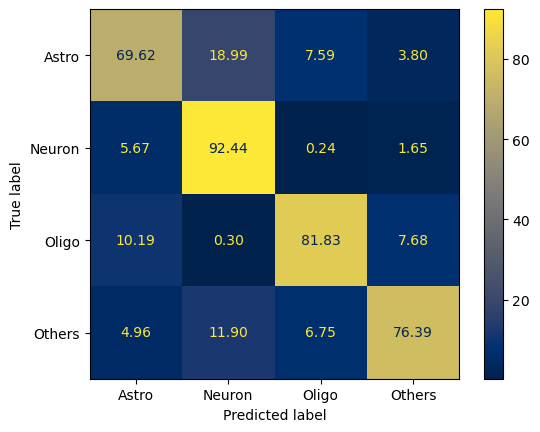

In [7]:
plot = ConfusionMatrixDisplay(final_cm_t,
                              display_labels=['Astro', 'Neuron', 'Oligo', 'Others'])
plot.plot(cmap='cividis', values_format='.2f')         
plt.show()

In [8]:
model = loaded_model
# Confusion matrix across 10 folds, WITH thresholding 
print('Macro avg F1 ', 
      mean([i['macro avg']['f1-score'] for i in model.cv_reportsT])*100)
print('Macro avg F1 std ', 
      np.std([i['macro avg']['f1-score'] for i in model.cv_reportsT])*100)

print("--------------------------")
print('Macro avg precision',
      mean([i['macro avg']['precision'] for i in model.cv_reportsT])*100)
print('Macro avg precision std',
      np.std([i['macro avg']['precision'] for i in model.cv_reportsT])*100)
print("--------------------------")
print('Macro avg recall ',
      mean([i['macro avg']['recall'] for i in model.cv_reportsT])*100)
print('Macro avg recall std',
      np.std([i['macro avg']['recall'] for i in model.cv_reportsT])*100)

Macro avg F1  77.52330200615246
Macro avg F1 std  6.055834848638435
--------------------------
Macro avg precision 78.13885679938454
Macro avg precision std 4.942448028487089
--------------------------
Macro avg recall  79.75250191689582
Macro avg recall std 6.226496206399468


In [9]:
model = loaded_model
# Confusion matrix across 10 folds, WITH NO thresholding 
print('Macro avg F1 ', 
      mean([i['macro avg']['f1-score'] for i in model.cv_reports])*100)
print('Macro avg F1 std ', 
      np.std([i['macro avg']['f1-score'] for i in model.cv_reports])*100)

print("--------------------------")
print('Macro avg precision',
      mean([i['macro avg']['precision'] for i in model.cv_reports])*100)
print('Macro avg precision std',
      np.std([i['macro avg']['precision'] for i in model.cv_reports])*100)
print("--------------------------")
print('Macro avg recall ',
      mean([i['macro avg']['recall'] for i in model.cv_reports])*100)
print('Macro avg recall std',
      np.std([i['macro avg']['recall'] for i in model.cv_reports])*100)

Macro avg F1  72.60259241107812
Macro avg F1 std  6.095672186804803
--------------------------
Macro avg precision 73.47431668102521
Macro avg precision std 5.473066632141943
--------------------------
Macro avg recall  76.02527526286238
Macro avg recall std 6.547465890235114


Plotting feature importance

In [10]:
import seaborn as sns

In [11]:
model_rf = joblib.load('/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Tuning_parameters/Results/cortical_random_search.sav')

In [12]:
model_rf.best_params_

{'selector__n_features_to_select': 38,
 'clf__sampling_strategy': 'not majority',
 'clf__random_state': 42,
 'clf__n_estimators': 900,
 'clf__min_samples_split': 5,
 'clf__min_samples_leaf': 4,
 'clf__max_samples': 0.5,
 'clf__max_features': 0.2,
 'clf__max_depth': None,
 'clf__class_weight': 'balanced'}

In [28]:
#With feature selection
rf_result = model_rf.best_estimator_.named_steps['selector'].get_support(indices=True)
rf_result
rf_result_f = [X_train.columns[i] for i in rf_result]
# (rf_result_f)
importance = model_rf.best_estimator_.named_steps['clf'].feature_importances_
f_importance = pd.DataFrame(data={'features':rf_result_f,'importance':importance})
f_importance = f_importance.sort_values(by=['importance'],ascending=False)

In [29]:
f_importance_subset = f_importance[0:11]
features = [i.replace('ROI: 0.25 µm per pixel: ','') for i in f_importance_subset['features']]
f_importance_subset = f_importance_subset.copy()
f_importance_subset.loc[:,'features'] = features
f_importance_subset = f_importance_subset.rename(columns={'features':'Feature',
                                    'importance':'Importance'})

In [30]:
f_importance_subset

,Feature,Importance
5,Nucleus: Max diameter µm,0.121259
1,Nucleus: Area µm^2,0.113244
2,Nucleus: Length µm,0.109141
11,Cell: Max diameter µm,0.108733
6,Nucleus: Min diameter µm,0.085914
8,Cell: Length µm,0.057553
3,Nucleus: Circularity,0.054355
7,Cell: Area µm^2,0.037978
0,Detection probability,0.037085
13,Nucleus/Cell area ratio,0.027191


<Axes: xlabel='Importance', ylabel='Feature'>

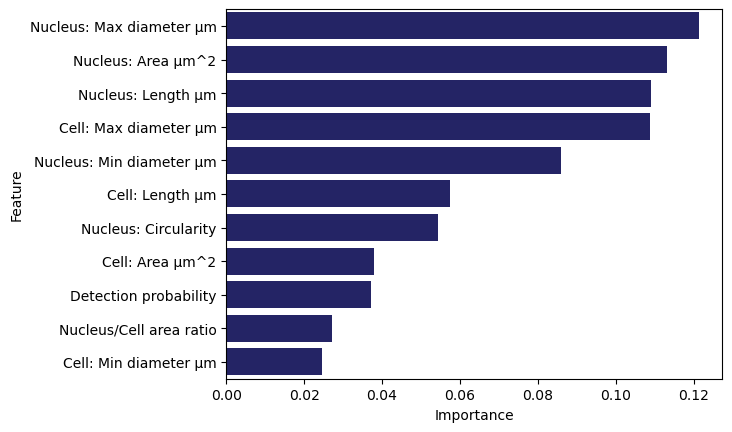

In [31]:
sns.barplot(data=f_importance_subset,
            y="Feature",
            x="Importance",
            color='midnightblue')

In [32]:
keys = ['split0_test_PR_AUC',
        'split1_test_PR_AUC',
        'split2_test_PR_AUC',
        'split3_test_PR_AUC',
        'split4_test_PR_AUC',
        'split5_test_PR_AUC',
        'split6_test_PR_AUC',
        'split7_test_PR_AUC',
        'split8_test_PR_AUC',
        'split9_test_PR_AUC']
pr_val = []
for i in keys:
    pr_val.append(model_rf.cv_results_[i][model_rf.best_index_])

In [33]:
print(model_rf.cv_results_['mean_test_PR_AUC'][model_rf.best_index_]*100)
print('mean pr:', mean(pr_val)*100)
print('std pr:', np.std(pr_val)*100)

79.98806241134216
mean pr: 79.98806241134216
std pr: 6.231450562111405
